# Exploratory Data Analysis

**Goal:**  

This notebook focuses on exploratory data analysis of the time series, with the objective of identifying seasonality, trends, and correlations. The data is curated and analyzed using time series plots, MSTL decomposition, autocorrelation (ACF) and partial autocorrelation (PACF) analysis to uncover temporal patterns and dependencies.

**Main Conclusion:**

Electricity demand in Germany exhibits strong daily and weekly seasonality, which makes naïve and seasonal baseline models highly competitive when compared to more complex forecasting approaches. As a result, explicitly encoding daily and weekly seasonal patterns is essential for developing models that can accurately forecast electricity consumption in Germany.

**Author:** Rodrigo Amorim

## Import the required Libraries and load the original dataset

In [1]:
# Load the necessary libraries
import pandas as pd 
import matplotlib.pyplot as plt 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import MSTL

In [6]:
# Load the dataset 
df = pd.read_csv(r"\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\Data\Raw\time_series_60min_singleindex.csv", usecols = ['cet_cest_timestamp','DE_load_actual_entsoe_transparency'], low_memory = True)
df.rename(columns = {"cet_cest_timestamp": "Date", "DE_load_actual_entsoe_transparency": "DE_Load"}, inplace = True)

In [ ]:
# Convert the date to the datetime64 type and index the dataset (crucial step for timeseries datasets) 
df["Date"] = pd.to_datetime(df["Date"], utc = True)
df = df.set_index("Date").sort_index()
df.index = df.index.tz_convert("Europe/Berlin")

## Data Curation

In [8]:
# Check if there are missing values
print(f"Missing Values: \n{df.isna().sum()}")

Missing Values: 
DE_Load    1
dtype: int64


In [ ]:
# Since the only missing value is the first value of 
# the dataset, this value is going to be substituted by the hourly consumption of the next day at the same hour
df.iloc[0, df.columns.get_loc("DE_Load")] = df["DE_Load"].iloc[24]

In [ ]:
# Remove the electricity consumption data from the covid year (Anomaly)
df = df.loc[df.index < "2020"]

## Data Analysis and Visualization 

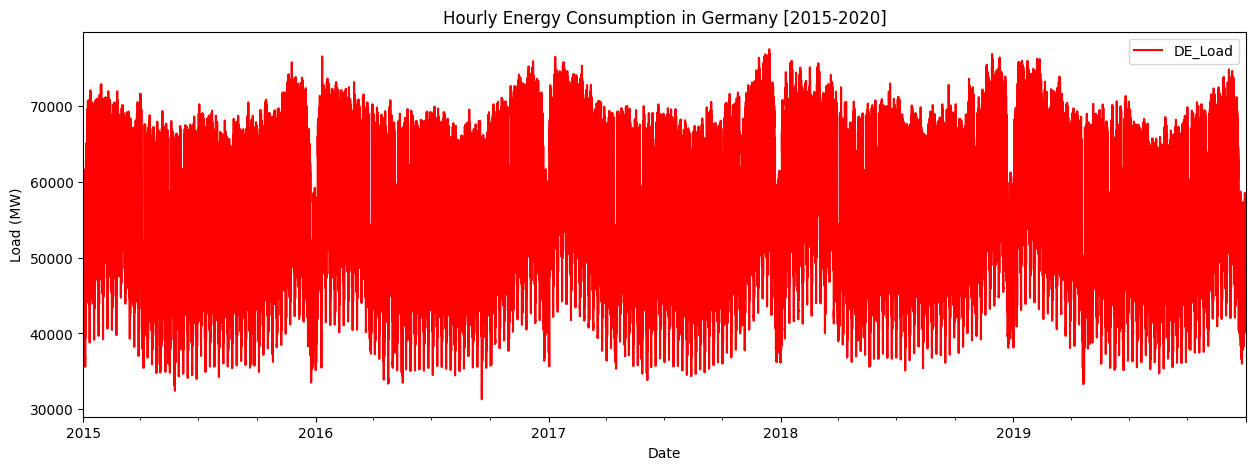

In [ ]:
# Plotting the dataset

df.plot(title="Hourly Energy Consumption in Germany [2015-2019]",figsize=(15,5), color = "red", xlabel= "Date", ylabel="Load (MW)")
plt.show()

As one can see from the figure above, the data exhibits strong daily, weekly and yearly seasonality. Next, the plots of the daily, weekly and monthly energy consumption across different time periods is going to be plotted to further analyze the consumption trend.

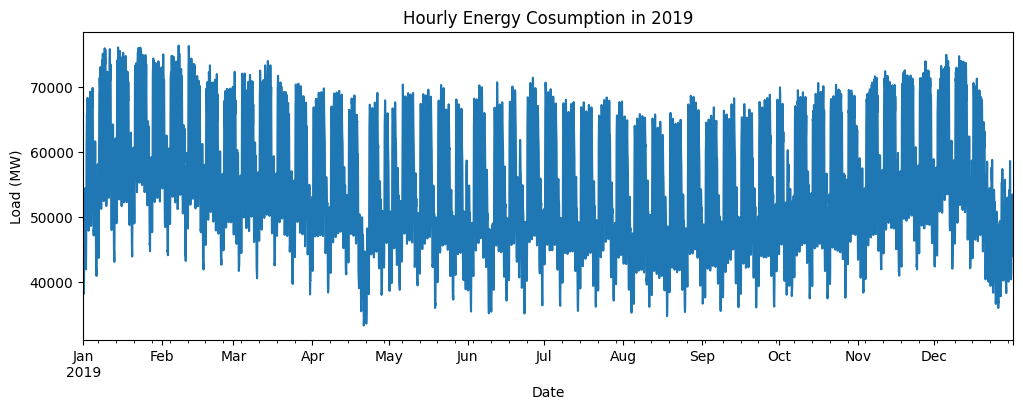

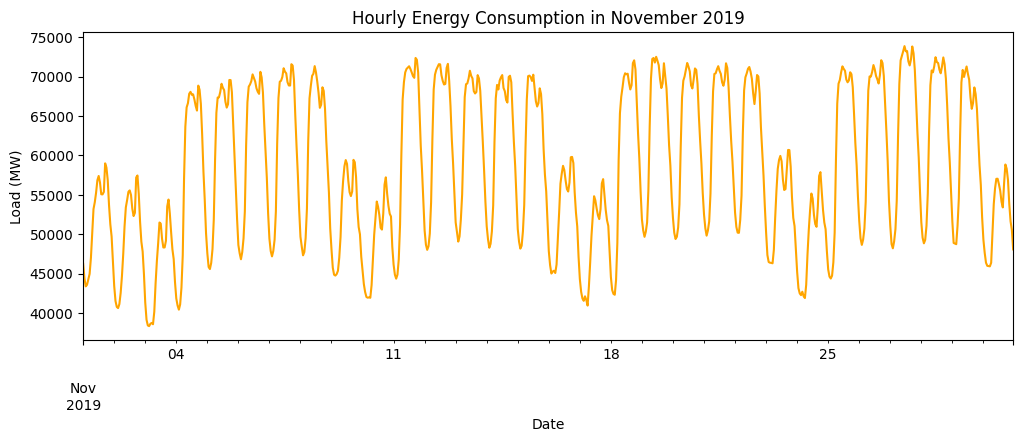

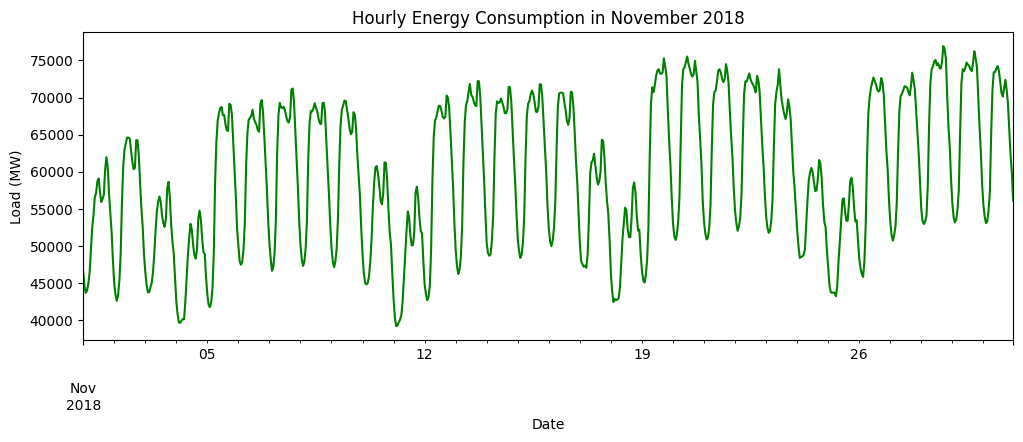

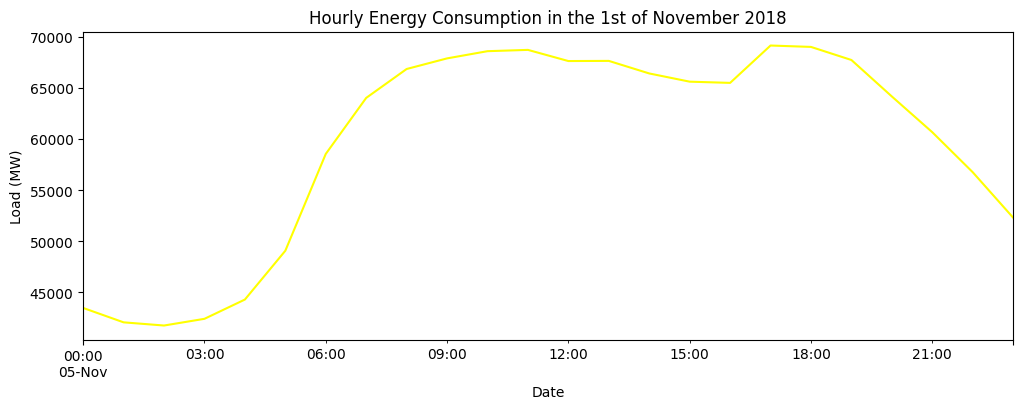

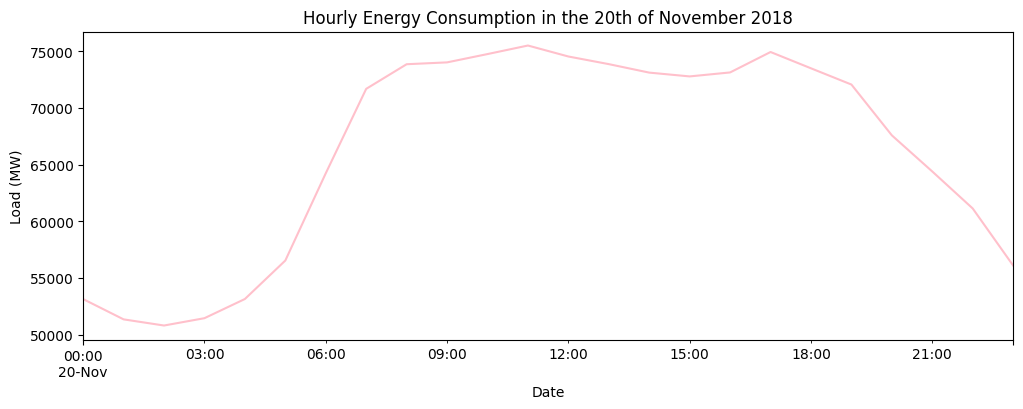

In [ ]:
# Plot different timestamps to check for seasonality and trends
df["DE_Load"]["2019"].plot(figsize=(12,4), title = "Hourly Energy Cosumption in 2019",xlabel= "Date", ylabel="Load (MW)")
plt.show()
df["DE_Load"]["2019-11"].plot(figsize=(12,4), title = "Hourly Energy Consumption in November 2019", color = "orange",xlabel= "Date", ylabel="Load (MW)")
plt.show()
df["DE_Load"]["2018-11"].plot(figsize=(12,4), title = "Hourly Energy Consumption in November 2018", color = "green",xlabel= "Date", ylabel="Load (MW)")
plt.show()
df["DE_Load"]["2018-11-05"].plot(figsize=(12,4), title = "Hourly Energy Consumption in the 1st of November 2018", color = "yellow",xlabel= "Date", ylabel="Load (MW)")
plt.show()
df["DE_Load"]["2018-11-20"].plot(figsize=(12,4), title = "Hourly Energy Consumption in the 20th of November 2018", color = "pink",xlabel= "Date", ylabel="Load (MW)")
plt.show()


**Analysis:**

From the plots above it is clear the timeseries data of the electricity consumption in Germany presentes daily, weekly and yearly seasonality patterns across different time periods.

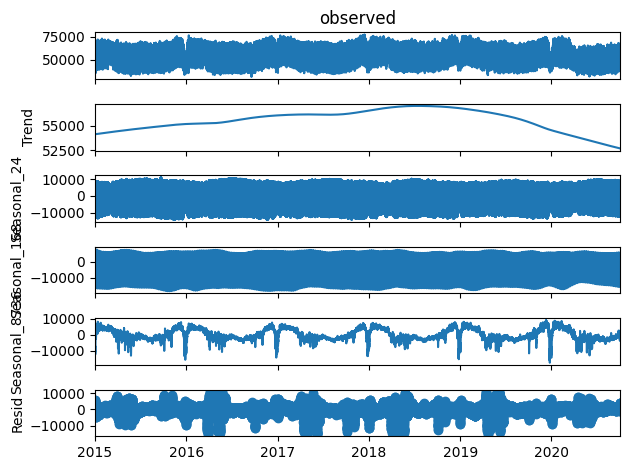

In [ ]:
# Next a MSTL(Multiple Seasonal-Trend decomposition using LOESS) analysis is performed to isolate and correctly identify multiple seasonal patterns 
res = MSTL(df, periods = (24, 24*7,24*7*52)).fit()
res.plot()
plt.show()

**Analysis:**

The MSTL decomposition reveals three dominant seasonalities in the hourly electricity consumption series: a strong daily cycle, a clear weekly pattern related to weekday–weekend behavior, and a smoother yearly seasonal component associated with climatic and calendar effects. The daily seasonality exhibits the highest amplitude and stability, suggesting it to be the primary driver of short-term variability. After removing these seasonal components and the long-term trend, the residual series shows limited remaining structure, indicating that most of the systematic variation is explained by the identified components.

<function matplotlib.pyplot.show(close=None, block=None)>

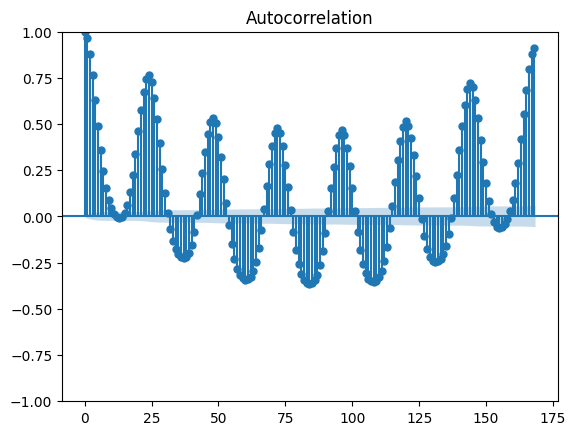

In [ ]:
# Plot the autocorrelation (How similar is the time series to a copy of itself shifted by k time steps?)
plot_acf(df,lags = 168)
plt.show


**Analysis:** 

The autocorrelation function shows very strong persistence at short lags, along with pronounced periodic peaks at multiples of 24 hours and a dominant peak at 168 hours. This confirms the presence of both daily and weekly seasonal structures, with the daily cycle being the most prominent. The oscillatory behavior between peaks reflects intraday demand shape differences between peak and off-peak hours.

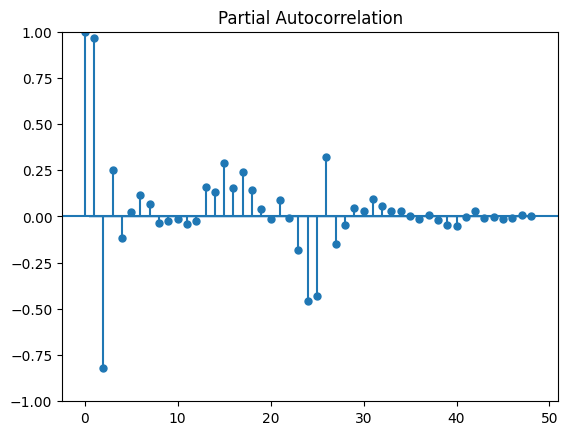

In [ ]:
# Plot the partial-autocorrelation to identify residual autoregressive dependence without the confounding effect of intermediary lags
plot_pacf(df, lags = 48)
plt.show()

**Analysis:**

The partial autocorrelation analysis reveals a strong short-term dependency at lag 1, confirming high persistence in hourly electricity demand. Significant spikes around lag 24 indicate pronounced daily seasonality, while additional structure at intermediate lags suggests interactions between intra-day and inter-day dynamics. The rapid decay of partial autocorrelations beyond 30–40 lags implies that long-term dependencies are primarily seasonal rather than autoregressive.

## Save the dataset

In [ ]:
# Save the processed dataset
df.to_parquet(r'C:\Users\rodri\Desktop\Energy_Consumption_Forecasting\End-to-End_Energy_Consumption_Forecasting\Data\Processed/GermanEnergyConsumption.parquet')
